In [1]:
from IPython.display import clear_output

!pip install pmdarima
!pip install streamlit
!pip install netCDF4

clear_output(wait=False)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import itertools
from math import sqrt
import matplotlib.pyplot as plt
import math

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

import datetime
from dateutil.relativedelta import relativedelta
import time

import streamlit as st
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

import xarray as xr
import netCDF4

In [4]:
sst_bck = xr.open_dataset('/content/drive/My Drive/sst.mon.mean.nc')['sst']
slp_bck = xr.open_dataset('/content/drive/My Drive/slp.nc',decode_times=False)

In [5]:
new_time = slp_bck['T'].to_numpy()
date_ref = datetime.date(1949,1,1)

new_time  = [date_ref+relativedelta(months=+math.floor(i)+132) for i in new_time]
new_time = [np.datetime64(i) for i in new_time]
slp_bck['T'] = ('T',new_time)
slp_bck = slp_bck['pressure']

In [6]:
slp_bck

<xarray.DataArray 'pressure' (T: 911, Y: 73, X: 144)> Size: 38MB
[9576432 values with dtype=float32]
Coordinates:
  * Y        (Y) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * X        (X) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * T        (T) datetime64[ns] 7kB 1949-01-01 1949-02-01 ... 2024-11-01
Attributes: (12/21)
    pointwidth:          1.0
    gribleveltype:       102
    gribvariable:        1
    calendar:            standard
    center:              US Weather Service - National Met. Center
    grib_name:           PRES
    ...                  ...
    long_name:           Pressure
    units:               mb
    file_missing_value:  9.999e+20
    scale_max:           1083.0
    scale_min:           959.47
    CI:                  2

In [7]:
lat_boundary_top = 5
lat_bounday_bottom = -5
long_boundary_left = 205
long_boundary_right = 216

sst = sst_bck.where(sst_bck['lat']> lat_bounday_bottom,drop=True)
sst = sst.where(sst['lat']< lat_boundary_top,drop=True)
sst = sst.where(sst['lon']> long_boundary_left,drop=True)
sst = sst.where(sst['lon']< long_boundary_right,drop=True)

sst = sst.where(sst['time.year']> 1981,drop=True)
sst = sst.where(sst['time.year']< 2024,drop=True)

slp = slp_bck.where(slp_bck['Y']> lat_bounday_bottom,drop=True)
slp = slp.where(slp['Y']< lat_boundary_top,drop=True)
slp = slp.where(slp['X']> long_boundary_left,drop=True)
slp = slp.where(slp['X']< long_boundary_right,drop=True)

slp = slp.where(slp['T.year']> 1981,drop=True)
slp = slp.where(slp['T.year']< 2024,drop=True)

timestamps = sst.coords['time'].values
sst_means = sst.mean(dim=['lat','lon']).values
slp_means = slp.mean(dim=['Y','X']).values

In [8]:
sst

<xarray.DataArray 'sst' (time: 504, lat: 40, lon: 44)> Size: 4MB
array([[[27.600323, 27.56516 , 27.546774, ..., 26.875807, 26.841612,
         26.829031],
        [27.566774, 27.492903, 27.488386, ..., 26.865807, 26.82645 ,
         26.816774],
        [27.534838, 27.468063, 27.461935, ..., 26.858065, 26.823547,
         26.800966],
        ...,
        [27.052258, 27.039999, 27.063225, ..., 26.969355, 27.010645,
         27.013548],
        [27.117418, 27.13516 , 27.179354, ..., 27.09129 , 27.14387 ,
         27.121935],
        [27.214516, 27.249031, 27.291935, ..., 27.172903, 27.214838,
         27.20129 ]],

       [[27.50357 , 27.502857, 27.525356, ..., 27.23    , 27.133928,
         27.079285],
        [27.409641, 27.444643, 27.468927, ..., 27.158928, 27.0675  ,
         27.0175  ],
        [27.33857 , 27.331072, 27.340357, ..., 27.045   , 26.998571,
         26.944284],
...
        [29.744   , 29.766998, 29.797333, ..., 29.057999, 29.110666,
         29.159332],
        [29.789665, 29.807999, 29.835999, ..., 29.177332, 29.219332,
         29.262   ],
        [29.833332, 29.841   , 29.860666, ..., 29.320665, 29.352667,
         29.373   ]],

       [[29.450321, 29.443226, 29.437418, ..., 28.63129 , 28.600645,
         28.571936],
        [29.440321, 29.438065, 29.436129, ..., 28.617096, 28.59387 ,
         28.569677],
        [29.428064, 29.424837, 29.424837, ..., 28.602257, 28.584192,
         28.560644],
        ...,
        [29.484838, 29.481289, 29.449677, ..., 29.157742, 29.150967,
         29.14    ],
        [29.534838, 29.54613 , 29.523226, ..., 29.187418, 29.182903,
         29.178709],
        [29.547419, 29.561935, 29.549677, ..., 29.22258 , 29.217419,
         29.21    ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1982-01-01 1982-02-01 ... 2023-12-01
  * lat      (lat) float32 160B -4.875 -4.625 -4.375 ... 4.375 4.625 4.875
  * lon      (lon) float32 176B 205.1 205.4 205.6 205.9 ... 215.4 215.6 215.9
Attributes:
    long_name:      Monthly Mean of Sea Surface Temperature
    units:          degC
    valid_range:    [-3. 45.]
    precision:      2.0
    dataset:        NOAA High-resolution Blended Analysis
    var_desc:       Sea Surface Temperature
    level_desc:     Surface
    statistic:      Monthly Mean
    parent_stat:    Individual Observations
    actual_range:   [-1.8  32.14]
    standard_name:  sea_surface_temperature

In [9]:
data = pd.DataFrame(columns=['Time','SST','SLP'])
data['Time'] = timestamps
data['SST'] = sst_means
data['SLP'] = slp_means

data['Time'] = pd.to_datetime(data['Time'], format='%y%m%d')
data = data.set_index('Time')

<Figure size 1000x600 with 0 Axes>

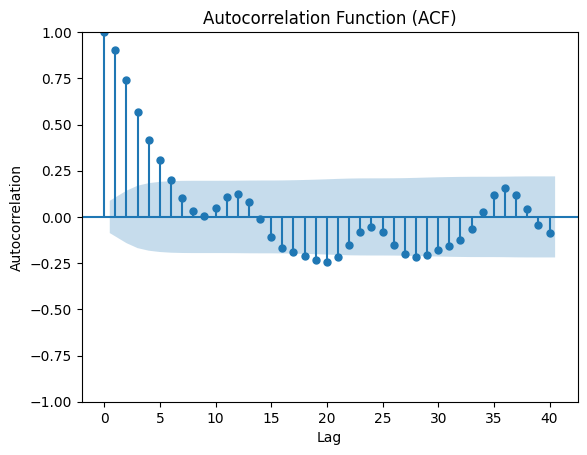

<Figure size 1000x600 with 0 Axes>

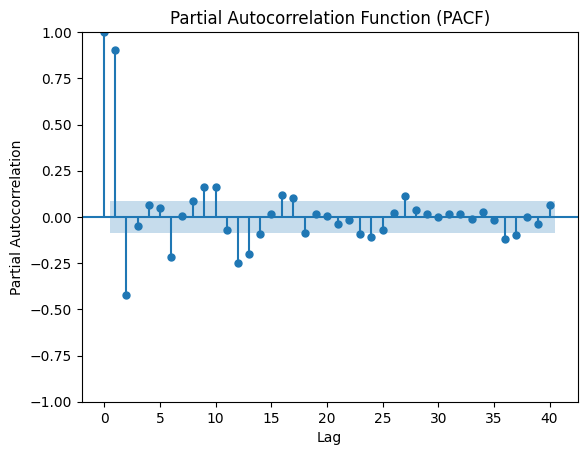

In [10]:
plt.figure(figsize=(10, 6))
plot_acf(data['SST'], lags=40)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.savefig('Pacific_ACF.png')
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(data['SST'], lags=40)
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.savefig('Pacific_PACF.png')
plt.show()

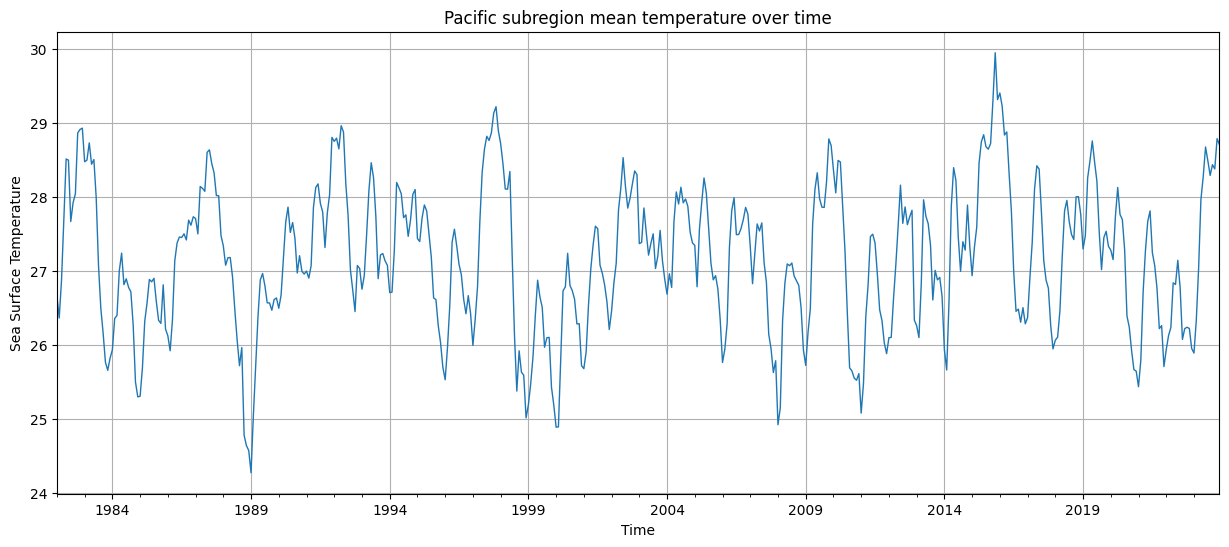

In [11]:
data['SST'].plot(grid=True, figsize=(15,6), linewidth=1)
plt.title('Pacific subregion mean temperature over time')
plt.ylabel('Sea Surface Temperature')
plt.savefig('Pacific_data.png')
plt.show()

In [12]:
print(f"P-value: {adfuller(data['SST'], autolag='AIC')[1]}")
print(f"Critical Value: {adfuller(data['SST'], autolag='AIC')[0]}")
print(f"Confidence Intervals: {adfuller(data['SST'], autolag='AIC')[-2]}")

P-value: 2.165233209203308e-05
Critical Value: -5.0054113768734645
Confidence Intervals: {'1%': -3.4438771098680196, '5%': -2.867505393939065, '10%': -2.569947324764179}


In [13]:
stepwise_model = auto_arima(data['SST'], stepwise=True, trace=True, stationary=True,start_p=2,start_q=5)
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=395.324, Time=1.79 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1407.362, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=537.381, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=905.769, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4761.175, Time=0.05 sec
 ARIMA(1,0,5)(0,0,0)[0] intercept   : AIC=425.652, Time=1.69 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=426.927, Time=1.49 sec
 ARIMA(3,0,5)(0,0,0)[0] intercept   : AIC=429.359, Time=1.99 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=423.992, Time=3.18 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=427.065, Time=6.95 sec
 ARIMA(2,0,5)(0,0,0)[0]             : AIC=450.966, Time=0.99 sec

Best model:  ARIMA(2,0,5)(0,0,0)[0] intercept
Total fit time: 18.664 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  504
Model:               SARIMAX(2, 0, 5)   Log Likelihood                -188.662
Date:                Thu, 12 Dec 2024   AIC                            395.324
Time:                        20:15:34   BIC                            433.327
Sample:                    01-01-1982   HQIC                           410.232
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.0636      0.619     11.415      0.000       5.851       8.276
ar.L1          1.4770      0.052     28.232      0.000       1.374       1.579
ar.L2         -0.7370      0.048    -15.295      0.000      -0.831      -0.643
ma.L1         -0.2794      0.059     -4.752      0.000      -0.395      -0.164
ma.L2          0.1187      0.047      2.532      0.011       0.027       0.211
ma.L3          0.1809      0.041      4.413      0.000       0.101       0.261
ma.L4          0.1967      0.045      4.345      0.000       0.108       0.285
ma.L5          0.4052      0.045      9.065      0.000       0.318       0.493
sigma2         0.1229      0.007     17.167      0.000       0.109       0.137
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                 3.98
Prob(Q):                              0.46   Prob(JB):                         0.14
Heteroskedasticity (H):               1.06   Skew:                            -0.01
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
params = stepwise_model.get_params()
order = params['order']
seasonal_order = params['seasonal_order']

n = int(data.shape[0]*0.2)

train, test = data['SST'].iloc[:-n], data['SST'].iloc[-n:]

model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)

model_fit = model.fit()
start = len(train)
end = len(train) + len(test) - 1
prediction = model_fit.predict(start=start, end=end)
prediction = prediction.rename('Prediction')

In [15]:
stepwise_model = auto_arima(data['SST'], stepwise=True, trace=True, stationary=True,start_p=2,start_q=5,exogenous=data['SLP'])
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=395.324, Time=1.75 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1407.362, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=537.381, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=905.769, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4761.175, Time=0.06 sec
 ARIMA(1,0,5)(0,0,0)[0] intercept   : AIC=425.652, Time=1.65 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=426.927, Time=1.68 sec
 ARIMA(3,0,5)(0,0,0)[0] intercept   : AIC=429.359, Time=5.66 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=423.992, Time=1.70 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=427.065, Time=1.75 sec
 ARIMA(2,0,5)(0,0,0)[0]             : AIC=450.966, Time=0.98 sec

Best model:  ARIMA(2,0,5)(0,0,0)[0] intercept
Total fit time: 15.816 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  504
Model:               SARIMAX(2, 0, 5)   Log Likelihood                -188.662
Date:                Thu, 12 Dec 2024   AIC                            395.324
Time:                        20:15:50   BIC                            433.327
Sample:                    01-01-1982   HQIC                           410.232
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.0636      0.619     11.415      0.000       5.851       8.276
ar.L1          1.4770      0.052     28.232      0.000       1.374       1.579
ar.L2         -0.7370      0.048    -15.295      0.000      -0.831      -0.643
ma.L1         -0.2794      0.059     -4.752      0.000      -0.395      -0.164
ma.L2          0.1187      0.047      2.532      0.011       0.027       0.211
ma.L3          0.1809      0.041      4.413      0.000       0.101       0.261
ma.L4          0.1967      0.045      4.345      0.000       0.108       0.285
ma.L5          0.4052      0.045      9.065      0.000       0.318       0.493
sigma2         0.1229      0.007     17.167      0.000       0.109       0.137
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                 3.98
Prob(Q):                              0.46   Prob(JB):                         0.14
Heteroskedasticity (H):               1.06   Skew:                            -0.01
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
params = stepwise_model.get_params()
order = params['order']
seasonal_order = params['seasonal_order']

train, test = data['SST'].iloc[:-n], data['SST'].iloc[-n:]

model = SARIMAX(train, exog=data['SLP'].iloc[:-n],order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)

model_fit = model.fit()
start = len(train)
end = len(train) + len(test) - 1
prediction2 = model_fit.predict(start=start, end=end,exog=data['SLP'].iloc[-n:])
prediction2 = prediction2.rename('Prediction')

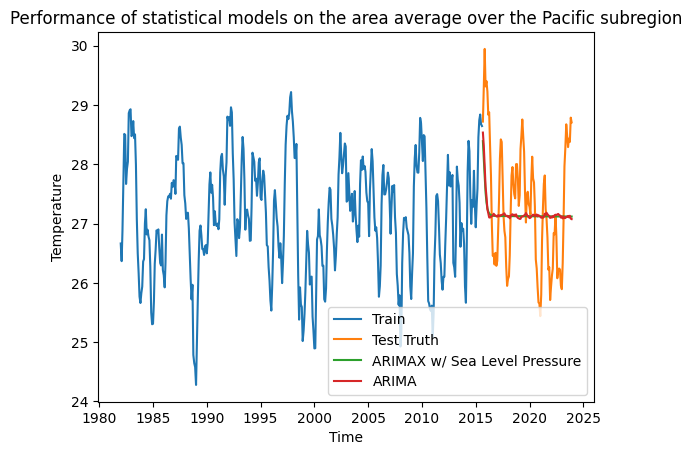

In [17]:
plt.plot(train.index,train,label='Train')
plt.plot(test.index, test, label='Test Truth')
plt.plot(test.index, prediction, label='ARIMAX w/ Sea Level Pressure')
plt.plot(test.index, prediction2, label='ARIMA')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Performance of statistical models on the area average over the Pacific subregion')
plt.show()

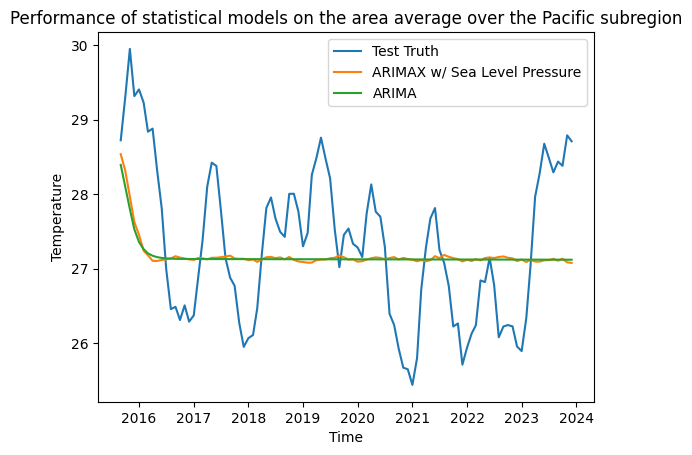

In [18]:
#plt.plot(train.index,train,label='Train')
plt.plot(test.index, test, label='Test Truth')
plt.plot(test.index, prediction2, label='ARIMAX w/ Sea Level Pressure')
plt.plot(test.index, prediction, label='ARIMA')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Performance of statistical models on the area average over the Pacific subregion')
plt.savefig('Pacific_statistical.png')
plt.show()

In [19]:
rmse = sqrt(mean_squared_error(test, prediction))
r2 = r2_score(test,prediction)
mae = (mean_absolute_error(test, prediction))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.8325403346484006
RMSE: 0.979225825361066
R2: 0.08568225257932838


In [20]:
rmse = sqrt(mean_squared_error(test, prediction2))
r2 = r2_score(test,prediction2)
mae = (mean_absolute_error(test, prediction2))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.8307492108068911
RMSE: 0.9742461927811042
R2: 0.09495772261438551


In [21]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,GRU

In [22]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R^2": r2}

In [23]:
time_series = data['SST'].values
split_index = data.shape[0]-n

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 10#len(test_data)  # Use 10 timesteps for prediction
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test sets
X_train, X_test = X[:split_index-sequence_length], X[split_index-sequence_length:]
y_train, y_test = y[:split_index-sequence_length], y[split_index-sequence_length:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

lstm_metrics = evaluate_model(y_test_rescaled, lstm_predictions)
lstm_metrics['Model'] = 'LSTM'
print(lstm_metrics)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2394
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1323
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0426
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0282
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0218
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0217
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0190
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0189
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0176
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0172
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0156
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0154
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0133 
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0143
Epoch 16/20
13/13 

In [24]:
bilstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(sequence_length, 1)),  # Bidirectional LSTM
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

# Train the model
bilstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
bilstm_predictions = bilstm_model.predict(X_test)
bilstm_predictions = scaler.inverse_transform(bilstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

bilstm_metrics = evaluate_model(y_test_rescaled, bilstm_predictions)
bilstm_metrics['Model'] = 'BiLSTM'
print(bilstm_metrics)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2609
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0954
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0242
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0235
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0215
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0206
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0180
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0199
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0168
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0153
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0147
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0124
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0134
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098
Epoch 16/20
13/13 

In [25]:
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(sequence_length, 1)),  # GRU layer
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

# Train the model
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

gru_metrics = evaluate_model(y_test_rescaled, gru_predictions)
gru_metrics['Model'] = 'GRU'
print(gru_metrics)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2363
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0833
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0204
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0131
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0127
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0120
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0107
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0099
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0088
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0094
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089
Epoch 16/2

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
{'MAE': 0.37565902, 'RMSE': 0.46487266, 'R^2': 0.7939373254776001, 'Model': 'GRU'}


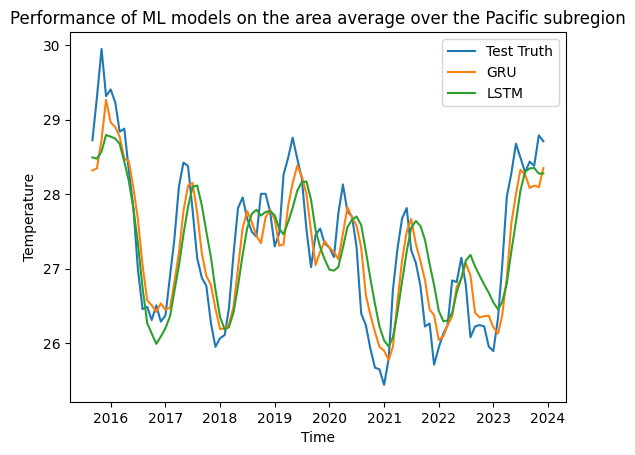

In [26]:
#plt.plot(train.index,train,label='Train')
plt.plot(test.index, test, label='Test Truth')
#plt.plot(test.index, prediction, label='Holt-Winters')
#plt.plot(test.index, [a+b for a,b in zip(prediction2.values,decomposition.seasonal.values[-n:])], label='Rebased ARIMA on non-seasonal component')
#plt.plot(test.index, prediction3, label='SARIMAX w/ Sea Level Pressure')
#plt.plot(test.index, prediction4, label='SARIMA')
plt.plot(test.index, gru_predictions, label='GRU')
plt.plot(test.index, lstm_predictions, label='LSTM')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Performance of ML models on the area average over the Pacific subregion')
plt.savefig('Pacific_ML.png')
plt.show()